## Caloric Suitability Index

This measure estimates "the potential (rather than actual) ... caloric yield per hectare per year, under low level of inputs and rain-fed agriculture, capturing cultivation methods that characterized early stages of development, while removing potential concerns that caloric yields.. Moreover, the estimates are based on agro-climatic constraints that are largely orthogonal to human intervention, mitigating further possible endogeneity." 
concerns.

> Galor, Oded, and Ömer Özak. 2016. “The Agricultural Origins of Time Preference.” American Economic Review 106 (10): 3064–103. https://doi.org/10.1257/aer.20150020.


Each cell is of size 5′ × 5′ (approximately 100 km2) across the globe.

Data at https://github.com/ozak/Caloric-Suitability-Index

In [1]:
import geopandas as gpd
import zipfile
import os
import rasterio
from rasterstats import zonal_stats

## Load data

### County border shapefile

In [2]:
#zip_path = 'map_data/cb_2024_us_county_20m.zip'
zip_path = 'map_data/tl_2010_us_county10.zip'
extract_dir = 'map_data/temp'

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_dir)

# List files in the extracted directory to verify shapefile name
print('Extracted files:', os.listdir(extract_dir))

# Find the .shp file in the extracted directory
shp_files = [f for f in os.listdir(extract_dir) if f.endswith('.shp')]
if shp_files:
    shapefile_path = os.path.join(extract_dir, shp_files[0])
    gdf = gpd.read_file(shapefile_path)
    # Exclude Alaska (02), Hawaii (15), and Puerto Rico (72) using STATEFP column
    exclude_fips = ['02', '15', '72']
    gdf = gdf[~gdf['STATEFP10'].isin(exclude_fips)]
    print(gdf.head(2))
else:
    print('No .shp file found in extracted directory.')

Extracted files: ['tl_2010_us_county10.dbf', 'tl_2010_us_county10.prj', 'tl_2010_us_county10.shp', 'tl_2010_us_county10.shp.xml', 'tl_2010_us_county10.shx']
  STATEFP10 COUNTYFP10 COUNTYNS10 GEOID10  NAME10     NAMELSAD10 LSAD10  \
2        28        107   00695776   28107  Panola  Panola County     06   
3        28        101   00695773   28101  Newton  Newton County     06   

  CLASSFP10 MTFCC10 CSAFP10 CBSAFP10 METDIVFP10 FUNCSTAT10     ALAND10  \
2        H1   G4020    None     None       None          A  1774515519   
3        H1   G4020    None     None       None          A  1497282694   

   AWATER10   INTPTLAT10    INTPTLON10  \
2  51767046  +34.3652052  -089.9630654   
3   3879399  +32.4019702  -089.1184115   

                                            geometry  
2  POLYGON ((-90.13476 34.22603, -90.13476 34.226...  
3  POLYGON ((-89.13497 32.57697, -89.13466 32.576...  
  STATEFP10 COUNTYFP10 COUNTYNS10 GEOID10  NAME10     NAMELSAD10 LSAD10  \
2        28        107   00

In [3]:
gdf.head()

,STATEFP10,COUNTYFP10,COUNTYNS10,GEOID10,NAME10,NAMELSAD10,LSAD10,CLASSFP10,MTFCC10,CSAFP10,CBSAFP10,METDIVFP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
2,28,107,00695776,28107,Panola,Panola County,06,H1,G4020,None,None,None,A,1774515519,51767046,+34.3652052,-089.9630654,"POLYGON ((-90.13476 34.22603, -90.13476 34.226..."
3,28,101,00695773,28101,Newton,Newton County,06,H1,G4020,None,None,None,A,1497282694,3879399,+32.4019702,-089.1184115,"POLYGON ((-89.13497 32.57697, -89.13466 32.576..."
4,28,027,00695738,28027,Coahoma,Coahoma County,06,H1,G4020,None,17260,None,A,1430818231,79539470,+34.2286699,-090.6031650,"POLYGON ((-90.59062 33.9869, -90.59473 33.9869..."
5,22,065,00558088,22065,Madison,Madison Parish,15,H1,G4020,None,45260,None,A,1617283455,68538668,+32.3658243,-091.2407290,"MULTIPOLYGON (((-91.03511 32.12035, -91.03621 ..."
6,51,540,01789068,51540,Charlottesville,Charlottesville city,25,C7,G4020,None,16820,None,F,26517362,52974,+38.0376579,-078.4853806,"POLYGON ((-78.47071 38.04872, -78.47033 38.048..."


In [4]:
# Define the path to your raster data
raster_path = "data/caloric/post1500AverageCalories0.tif"

with rasterio.open(raster_path) as src:
    raster_crs = src.crs

In [5]:
gdf = gdf.to_crs(raster_crs)

In [6]:
# Calculate the mean value of the raster for each county
# This returns a list of dictionaries, one for each county
stats = zonal_stats(gdf, 
                    raster_path,
                    stats="mean min max median", # Specify stats you want
                    geojson_out=True) # Makes it easy to merge back

In [7]:
# Convert the results to a new GeoDataFrame
stats_gdf = gpd.GeoDataFrame.from_features(stats)

# You can now see columns like 'mean', 'min', 'max' in this GeoDataFrame
stats_gdf.head(2)


,geometry,STATEFP10,COUNTYFP10,COUNTYNS10,GEOID10,NAME10,NAMELSAD10,LSAD10,CLASSFP10,MTFCC10,...,METDIVFP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,min,max,mean,median
0,"POLYGON ((-90.13476 34.22603, -90.13476 34.226...",28,107,00695776,28107,Panola,Panola County,06,H1,G4020,...,None,A,1774515519,51767046,+34.3652052,-089.9630654,5195.800293,5288.874023,5235.507188,5227.433594
1,"POLYGON ((-89.13497 32.57697, -89.13466 32.576...",28,101,00695773,28101,Newton,Newton County,06,H1,G4020,...,None,A,1497282694,3879399,+32.4019702,-089.1184115,4233.979004,4308.774902,4274.848047,4276.801758


In [8]:
# Select the columns you want to save
columns_to_save = ['STATEFP', 'GEOID', 'STUSPS', 'STATE_NAME', 'ALAND', 'AWATER', 'min', 'max', 'mean', 'median']

# Create a DataFrame with only the selected columns (drop geometry for CSV)
csv_data = stats_gdf[columns_to_save].copy()

# Save to CSV
csv_data.to_csv('data/caloric/county_caloric_suitability.csv', index=False)

print(f"CSV file saved with {len(csv_data)} counties")
print(f"Columns: {list(csv_data.columns)}")
csv_data.head(2)

KeyError: "['STATEFP', 'GEOID', 'STUSPS', 'STATE_NAME', 'ALAND', 'AWATER'] not in index"

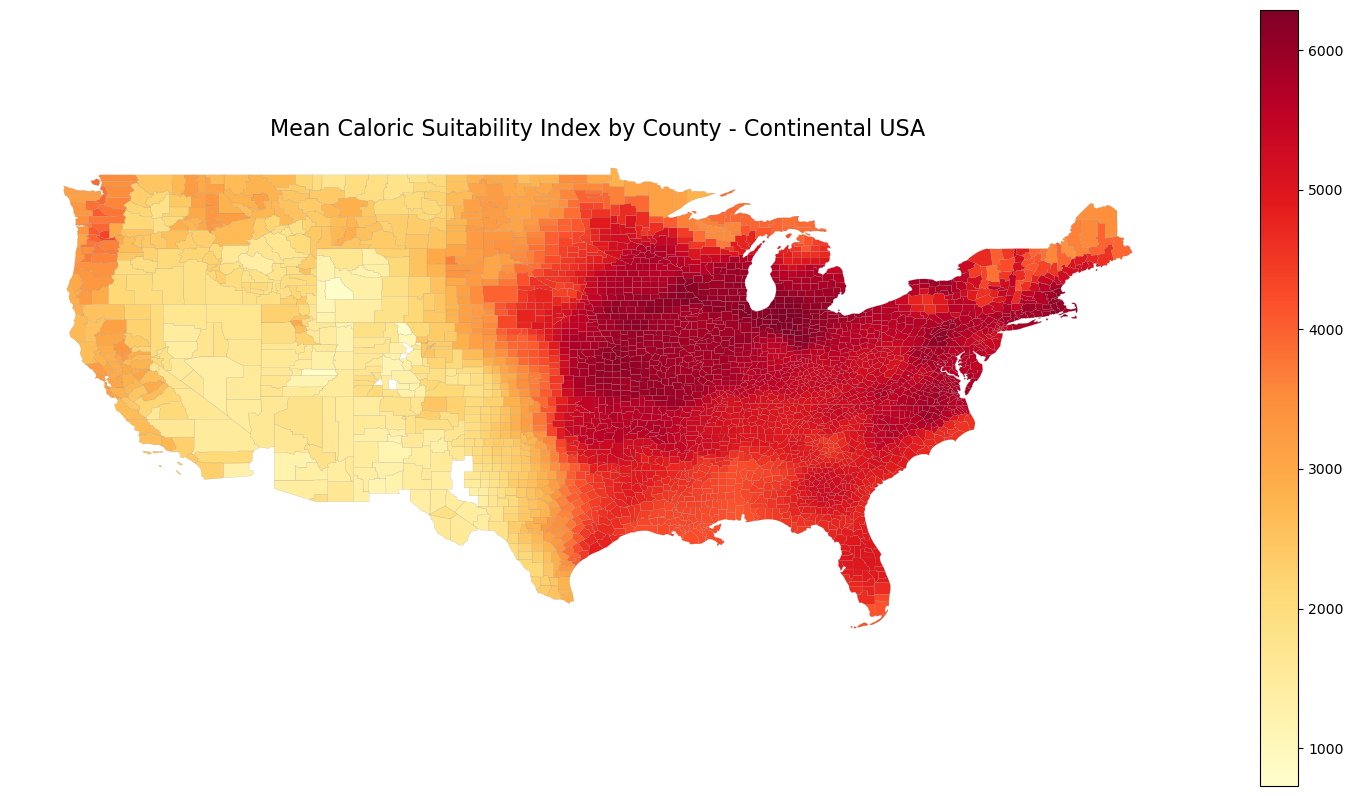

In [ ]:
import matplotlib.pyplot as plt

# Create a choropleth map of mean caloric suitability
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the counties shaded by mean caloric suitability
stats_gdf.plot(
    column='mean',
    cmap='YlOrRd',
    linewidth=0.1,
    ax=ax,
    edgecolor='gray',
    legend=True,
    legend_kwds={'shrink': 0.8}
)

ax.set_title('Mean Caloric Suitability Index by County - Continental USA', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()